<p><a href="https://colab.research.google.com/github/compgeog/choropleth-tradeoffs/blob/main/explore_choropleth_results.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></p>

# Choropleth map generation for analysis of choropleth classes


This notebook is used to generate choropleth maps to analyze classes of enumeration units by both humans and computers 

The following cell makes sure the necessary libraries and modules are imported to run the experiments in the rest of this notebook.

In [1]:
from geom.shapex import *
from spatialanalysis.moransi2 import *
from cgl.cgl.util.get_adjacency_matrix import *
from cgl.cgl.util.draw_polygons_shapex import *
from cgl.cgl.util.get_attribute_by_name import *
from cgl.cgl.util.evaluate_all import *
from cgl.cgl.util.pareto_ranking import *
from cgl.cgl.util.parallel_coordinates import *
from cgl.cgl.util.xcolorbrewer import *
from cgl.cgl.util.breakpoints2 import *

import time
import random
# random.seed(10)
import numpy as np
import pickle
import math

import urllib.request as request

import json

import matplotlib.pyplot as plt
%matplotlib inline


# Map Data

In this tutorial, we use the data of 1959 Illinois farm products. This data set has been used in many cartographic studies such as [this](https://www.tandfonline.com/doi/full/10.1111/1467-8306.9303005). The data is converted to a GeoJSON file and can be loaded directly from its [github source](https://raw.githubusercontent.com/compgeog/choropleth-tradeoffs/main/data/il/il.geojson).

In [2]:
# url_il_data = 'https://raw.githubusercontent.com/gisalgs/data/master/OH_geog.geojson'
# with request.urlopen(url_il_data) as response:
#     shp = json.loads(response.read())

baseMapPath = r'C:\Users\jiali\Desktop\choroColorRead\surveyMaking\baseMaps'
f = open(baseMapPath + '\\' + 'uscnty48area_102008.geojson')
shp = json.load(f)

all_features = shp['features']
print(len(all_features))
baseMap = 'us'

3109


In [3]:
all_features[0].keys()

dict_keys(['type', 'properties', 'geometry'])

In [4]:
all_features[0]['properties'].keys()

dict_keys(['NAME', 'STATE_NAME', 'FIPS', 'UrbanPop', 'Area', 'AreaKM2', 'GEO_ID', 'PopDensity'])

We need to get the bounds of the coordinates for each enumeration unit:

In [5]:
envelopes = get_feature_envelopes(all_features) # list of [xmin, ymin, xmax, ymax]
# geom_bounds = [min([p[0] for p in envelopes]), min([p[1] for p in envelopes]), max([p[2] for p in envelopes]), max([p[3] for p in envelopes])]
geom_bounds = {
    'xmin': min([p[0] for p in envelopes]), 
    'ymin': min([p[1] for p in envelopes]), 
    'xmax': max([p[2] for p in envelopes]), 
    'ymax': max([p[3] for p in envelopes])
}

geom_bounds # [xmin, ymin, xmax, ymax]

{'xmin': -2235809.497613872,
 'ymin': -1643544.949341902,
 'xmax': 2125197.68616152,
 'ymax': 1322159.8643133966}

Let's quickly draw a map to make sure the geometries are loaded correctly.

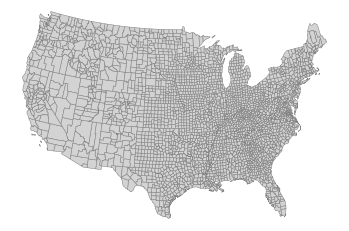

In [6]:
draw_shape(all_features)
plt.axis('off')
plt.axis('equal')
plt.show()

With the data loaded, we need to obtain the adjacency matrix (list), all the values of the attribute synthesized by us, and all the unique values (sorted). 

In [7]:
# adjacent list for the enumration units
adjacency_list = adjacency_matrix(all_features, output='L')
adjacency_list

[[3, 2],
 [5, 2],
 [5, 4],
 [6, 2],
 [6, 4],
 [6, 5],
 [7, 3],
 [8, 3],
 [9, 3],
 [9, 7],
 [10, 3],
 [10, 8],
 [10, 9],
 [11, 9],
 [11, 10],
 [12, 11],
 [13, 12],
 [14, 12],
 [14, 13],
 [15, 14],
 [16, 14],
 [16, 15],
 [17, 16],
 [21, 4],
 [21, 5],
 [23, 22],
 [25, 19],
 [25, 23],
 [25, 24],
 [26, 19],
 [26, 23],
 [26, 25],
 [27, 26],
 [28, 20],
 [28, 27],
 [29, 21],
 [30, 20],
 [30, 21],
 [30, 28],
 [30, 29],
 [31, 21],
 [31, 29],
 [31, 30],
 [32, 4],
 [32, 21],
 [32, 31],
 [34, 33],
 [35, 33],
 [36, 34],
 [38, 37],
 [40, 39],
 [41, 40],
 [42, 36],
 [42, 37],
 [43, 42],
 [44, 43],
 [45, 19],
 [45, 20],
 [45, 26],
 [45, 27],
 [45, 28],
 [46, 44],
 [47, 0],
 [50, 31],
 [50, 32],
 [50, 48],
 [51, 35],
 [53, 43],
 [53, 44],
 [53, 52],
 [54, 45],
 [54, 51],
 [55, 51],
 [55, 52],
 [57, 56],
 [58, 56],
 [59, 30],
 [59, 31],
 [59, 50],
 [60, 51],
 [60, 54],
 [60, 55],
 [60, 56],
 [60, 57],
 [61, 20],
 [61, 45],
 [61, 54],
 [61, 59],
 [62, 20],
 [62, 30],
 [62, 59],
 [62, 61],
 [63, 48],
 [63,

Specify the parameters to synthesize maps besides base map, including color scheme, number of classes

In [8]:
numclass = 4
colorScheme = 'Blues'
# colorScheme = 'RdBu'

#### 1. Generate spatial data (all values) with negative spatial autocorrelation for the enumeration units

##### (1) Use checker board with full negative spatial autocorrelation to overlap with the base map (doesn't work to synthesize data with significant negative spatial autocorrelation)

In [9]:
# power = 6
# size = 2**power + 1
# size = 8
# negAutoCorMatrix = np.zeros(shape=(size, size))
# size

In [10]:
# for i in range(size):
#     for j in range(size):
#         if (i + j) % 2 == 0:
#             x = random.uniform(0.5, 1)
#         else:
#             x = random.uniform(0, 0.5)
#         negAutoCorMatrix[i][j] = x
# H_scaled = negAutoCorMatrix
# plt.imshow(H_scaled, interpolation='none')
# plt.colorbar(orientation='vertical')
# plt.show()

##### (2) Use BFS to synthesize data for units and adjacent units to make sure they are not in the same class  

In [11]:
# find units adjacent to target unit
def getAdjacentUnits(adjacency_list, targetID):
    adjUnitList = []
    for pair in adjacency_list:
        if pair[0] == targetID:
            adjUnitList.append(pair[1])
        elif pair[1] == targetID:
            adjUnitList.append(pair[0])
    return adjUnitList

Initialize all_values with the same size of all_features, and assign small value to the first value in all_values

In [12]:
all_values = [-1 for i in range(len(all_features))] # initialize all_values with the same size of all_features
all_values[0] = random.uniform(0.5, 1)
visitedIDs = set()
visitedIDs.add(0)
currentQueue = []
currentQueue.append(0)

Generate data with negative spatial autocorrelation

In [13]:
while len(currentQueue) != 0:
    i =  currentQueue.pop(0)
    name =  all_features[i]['properties']['NAME']
    geoID =  all_features[i]['properties']['GEO_ID']
    print('name: %s geoID: %s' %(name, geoID))
    adjUnitList = getAdjacentUnits(adjacency_list,i)
    for adjUnit in adjUnitList:
        if adjUnit not in visitedIDs:
            if all_values[i] > 0.5:
                all_values[adjUnit] = random.uniform(0, 0.5)
            else:
                all_values[adjUnit] = random.uniform(0.5, 1)
            visitedIDs.add(adjUnit)
            currentQueue.append(adjUnit)
for i in range(len(all_values)):
    if all_values[i] == -1:
        all_values[i] = random.uniform(0, 1)
all_values_neg = all_values

name: Gallatin geoID: 05000US30031
name: Madison geoID: 05000US30057
name: Meagher geoID: 05000US30059
name: Jefferson geoID: 05000US30043
name: Park geoID: 05000US30067
name: Broadwater geoID: 05000US30007
name: Teton geoID: 05000US56039
name: Park geoID: 05000US56029
name: Fremont geoID: 05000US16043
name: Silver Bow geoID: 05000US30093
name: Beaverhead geoID: 05000US30001
name: Lewis and Clark geoID: 05000US30049
name: Judith Basin geoID: 05000US30045
name: Cascade geoID: 05000US30013
name: Wheatland geoID: 05000US30107
name: Sweet Grass geoID: 05000US30097
name: Powell geoID: 05000US30077
name: Deer Lodge geoID: 05000US30023
name: Carbon geoID: 05000US30009
name: Stillwater geoID: 05000US30095
name: Fremont geoID: 05000US56013
name: Lincoln geoID: 05000US56023
name: Bonneville geoID: 05000US16019
name: Teton geoID: 05000US16081
name: Sublette geoID: 05000US56035
name: Hot Springs geoID: 05000US56017
name: Big Horn geoID: 05000US56003
name: Washakie geoID: 05000US56043
name: Clark g

name: Corson geoID: 05000US46031
name: Grant geoID: 05000US38037
name: Piute geoID: 05000US49031
name: Garfield geoID: 05000US49017
name: Navajo geoID: 05000US04017
name: Coconino geoID: 05000US04005
name: Apache geoID: 05000US04001
name: Kane geoID: 05000US49025
name: San Miguel geoID: 05000US08113
name: Dolores geoID: 05000US08033
name: Montezuma geoID: 05000US08083
name: San Juan geoID: 05000US35045
name: Beaver geoID: 05000US49001
name: Ouray geoID: 05000US08091
name: Washington geoID: 05000US08121
name: Yuma geoID: 05000US08125
name: Sedgwick geoID: 05000US08115
name: Phillips geoID: 05000US08095
name: Denver geoID: 05000US08031
name: Arapahoe geoID: 05000US08005
name: Douglas geoID: 05000US08035
name: Teller geoID: 05000US08119
name: Garden geoID: 05000US31069
name: Sheridan geoID: 05000US31161
name: Deuel geoID: 05000US31049
name: Fremont geoID: 05000US08043
name: Saguache geoID: 05000US08109
name: Hinsdale geoID: 05000US08053
name: Dewey geoID: 05000US46041
name: Stanley geoID:

name: Ellis geoID: 05000US40045
name: Lipscomb geoID: 05000US48295
name: Harper geoID: 05000US40059
name: Roberts geoID: 05000US48393
name: Hemphill geoID: 05000US48211
name: Gray geoID: 05000US48179
name: Donley geoID: 05000US48129
name: Briscoe geoID: 05000US48045
name: Plymouth geoID: 05000US19149
name: Woodbury geoID: 05000US19193
name: Monona geoID: 05000US19133
name: Burt geoID: 05000US31021
name: Dodge geoID: 05000US31053
name: Saunders geoID: 05000US31155
name: Lyon geoID: 05000US27083
name: Murray geoID: 05000US27101
name: Nobles geoID: 05000US27105
name: Osceola geoID: 05000US19143
name: O'Brien geoID: 05000US19141
name: Cherokee geoID: 05000US19035
name: Seward geoID: 05000US31159
name: Saline geoID: 05000US31151
name: Jefferson geoID: 05000US31095
name: Washington geoID: 05000US20201
name: Cloud geoID: 05000US20029
name: Mitchell geoID: 05000US20123
name: Lancaster geoID: 05000US31109
name: Roseau geoID: 05000US27135
name: Beltrami geoID: 05000US27007
name: Pennington geoID

name: Burnett geoID: 05000US55013
name: Chisago geoID: 05000US27025
name: Washington geoID: 05000US27163
name: Ramsey geoID: 05000US27123
name: Steele geoID: 05000US27147
name: Goodhue geoID: 05000US27049
name: Dodge geoID: 05000US27039
name: Pierce geoID: 05000US55093
name: Atascosa geoID: 05000US48013
name: La Salle geoID: 05000US48283
name: McMullen geoID: 05000US48311
name: Bexar geoID: 05000US48029
name: Comal geoID: 05000US48091
name: Jim Hogg geoID: 05000US48247
name: Zapata geoID: 05000US48505
name: Duval geoID: 05000US48131
name: Travis geoID: 05000US48453
name: Burnet geoID: 05000US48053
name: Hays geoID: 05000US48209
name: Lampasas geoID: 05000US48281
name: Mills geoID: 05000US48333
name: Comanche geoID: 05000US48093
name: Eastland geoID: 05000US48133
name: Woodson geoID: 05000US20207
name: Wilson geoID: 05000US20205
name: Montgomery geoID: 05000US20125
name: Washington geoID: 05000US40147
name: Pawnee geoID: 05000US40117
name: Tulsa geoID: 05000US40143
name: Payne geoID: 05

name: Putnam geoID: 05000US17155
name: Tazewell geoID: 05000US17179
name: Woodford geoID: 05000US17203
name: Logan geoID: 05000US17107
name: Menard geoID: 05000US17129
name: Montgomery geoID: 05000US17135
name: Christian geoID: 05000US17021
name: Macon geoID: 05000US17115
name: Kendall geoID: 05000US17093
name: Kane geoID: 05000US17089
name: Lake geoID: 05000US17097
name: Cook geoID: 05000US17031
name: St. Francois geoID: 05000US29187
name: Madison geoID: 05000US29123
name: Wayne geoID: 05000US29223
name: Butler geoID: 05000US29023
name: Ste. Genevieve geoID: 05000US29186
name: Monroe geoID: 05000US17133
name: St. Clair geoID: 05000US17163
name: Clinton geoID: 05000US17027
name: Bond geoID: 05000US17005
name: Jefferson Davis geoID: 05000US22053
name: Vermilion geoID: 05000US22113
name: Rapides geoID: 05000US22079
name: Allen geoID: 05000US22003
name: Lawrence geoID: 05000US05075
name: Clay geoID: 05000US05021
name: Greene geoID: 05000US05055
name: Jackson geoID: 05000US05067
name: Wood

name: Lyon geoID: 05000US21143
name: Trigg geoID: 05000US21221
name: Calloway geoID: 05000US21035
name: Henry geoID: 05000US47079
name: Benton geoID: 05000US47005
name: Decatur geoID: 05000US47039
name: Henderson geoID: 05000US47077
name: Chester geoID: 05000US47023
name: McNairy geoID: 05000US47109
name: Alcorn geoID: 05000US28003
name: Tippah geoID: 05000US28139
name: Prentiss geoID: 05000US28117
name: Lee geoID: 05000US28081
name: Webster geoID: 05000US21233
name: Daviess geoID: 05000US21059
name: McLean geoID: 05000US21149
name: Dubois geoID: 05000US18037
name: Spencer geoID: 05000US18147
name: St. Tammany geoID: 05000US22103
name: Washington geoID: 05000US22117
name: St. Bernard geoID: 05000US22087
name: Chickasaw geoID: 05000US28017
name: Clay geoID: 05000US28025
name: Oktibbeha geoID: 05000US28105
name: Kemper geoID: 05000US28069
name: Lauderdale geoID: 05000US28075
name: Newton geoID: 05000US28101
name: Noxubee geoID: 05000US28103
name: Jasper geoID: 05000US28061
name: Smith ge

name: Kalkaska geoID: 05000US26079
name: Roscommon geoID: 05000US26143
name: Crawford geoID: 05000US26039
name: Ogemaw geoID: 05000US26129
name: Arenac geoID: 05000US26011
name: Wilson geoID: 05000US47189
name: Macon geoID: 05000US47111
name: Trousdale geoID: 05000US47169
name: Coffee geoID: 05000US47031
name: Bedford geoID: 05000US47003
name: Cannon geoID: 05000US47015
name: Moore geoID: 05000US47127
name: Franklin geoID: 05000US47051
name: Marshall geoID: 05000US01095
name: Jackson geoID: 05000US01071
name: Etowah geoID: 05000US01055
name: Monroe geoID: 05000US21171
name: Cumberland geoID: 05000US21057
name: Adair geoID: 05000US21001
name: Montgomery geoID: 05000US01101
name: Crenshaw geoID: 05000US01041
name: Covington geoID: 05000US01039
name: Coosa geoID: 05000US01037
name: Elmore geoID: 05000US01051
name: Santa Rosa geoID: 05000US12113
name: Okaloosa geoID: 05000US12091
name: Talladega geoID: 05000US01121
name: Calhoun geoID: 05000US01015
name: Campbell geoID: 05000US21037
name: 

name: Columbiana geoID: 05000US39029
name: Harrison geoID: 05000US39067
name: Washington geoID: 05000US39167
name: Wood geoID: 05000US54107
name: Belmont geoID: 05000US39013
name: Monroe geoID: 05000US39111
name: Mason geoID: 05000US54053
name: Jackson geoID: 05000US54035
name: Cabell geoID: 05000US54011
name: Boyd geoID: 05000US21019
name: Wayne geoID: 05000US54099
name: Loudon geoID: 05000US47105
name: Knox geoID: 05000US47093
name: Union geoID: 05000US47173
name: Monroe geoID: 05000US47123
name: Fannin geoID: 05000US13111
name: Cherokee geoID: 05000US37039
name: Dawson geoID: 05000US13085
name: Sumter geoID: 05000US13261
name: Terrell geoID: 05000US13273
name: Taylor geoID: 05000US13269
name: Schley geoID: 05000US13249
name: Upson geoID: 05000US13293
name: Pike geoID: 05000US13231
name: Dougherty geoID: 05000US13095
name: Jefferson geoID: 05000US12065
name: Thomas geoID: 05000US13275
name: Colquitt geoID: 05000US13071
name: Worth geoID: 05000US13321
name: Hall geoID: 05000US13139
na

name: Clay geoID: 05000US12019
name: Bradford geoID: 05000US12007
name: Putnam geoID: 05000US12107
name: Lake geoID: 05000US12069
name: Volusia geoID: 05000US12127
name: Sumter geoID: 05000US12119
name: Hernando geoID: 05000US12053
name: Brantley geoID: 05000US13025
name: Pierce geoID: 05000US13229
name: Edgefield geoID: 05000US45037
name: Columbia geoID: 05000US13073
name: Richmond geoID: 05000US13245
name: Caldwell geoID: 05000US37027
name: Wilkes geoID: 05000US37193
name: Floyd geoID: 05000US51063
name: Patrick geoID: 05000US51141
name: Yadkin geoID: 05000US37197
name: Forsyth geoID: 05000US37067
name: Stokes geoID: 05000US37169
name: Huntingdon geoID: 05000US42061
name: Fulton geoID: 05000US42057
name: Washington geoID: 05000US24043
name: Morgan geoID: 05000US54065
name: Union geoID: 05000US42119
name: Columbia geoID: 05000US42037
name: Northumberland geoID: 05000US42097
name: Montour geoID: 05000US42093
name: Bradford geoID: 05000US42015
name: Sullivan geoID: 05000US42113
name: Ch

name: Fredericksburg geoID: 05000US51630
name: Caroline geoID: 05000US51033
name: King William geoID: 05000US51101
name: New Kent geoID: 05000US51127
name: Marlboro geoID: 05000US45069
name: Williamsburg geoID: 05000US45089
name: Dillon geoID: 05000US45033
name: Marion geoID: 05000US45067
name: Georgetown geoID: 05000US45043
name: Charleston geoID: 05000US45019
name: Beaufort geoID: 05000US45013
name: Lee geoID: 05000US12071
name: Collier geoID: 05000US12021
name: Broward geoID: 05000US12011
name: Durham geoID: 05000US37063
name: Harnett geoID: 05000US37085
name: Lee geoID: 05000US37105
name: Wake geoID: 05000US37183
name: Hoke geoID: 05000US37093
name: Scotland geoID: 05000US37165
name: Cumberland geoID: 05000US37051
name: Baltimore City geoID: 05000US24510
name: Calvert geoID: 05000US24009
name: King George geoID: 05000US51099
name: St. Mary's geoID: 05000US24037
name: Passaic geoID: 05000US34031
name: Orange geoID: 05000US36071
name: Morris geoID: 05000US34027
name: Hunterdon geoID:

In [14]:
unique_values = list(set(all_values_neg))
m = len(all_values_neg)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

3109 3109 0.0005802903729386077 0.999608844099795


We can also show a histogram of the data.

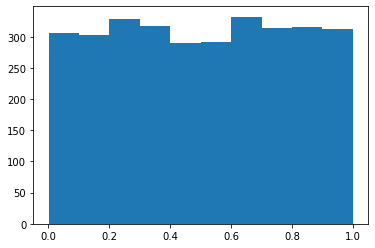

In [15]:
plt.hist(all_values_neg)
plt.show()

##### Defining a classification

A Python class called `Intervals` is defined in the [classify.py](https://github.com/compgeog/cgl/blob/master/cgl/util/classify.py) that will be cloned here (see the beginning of this tutorial). There are multiple ways to create a classification. Below is an example using a set of lower and upper bounds:

In [16]:
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.25], [0.25 - 0.5], [0.5 - 0.75], [0.75 - 1]

We can draw a choropleth map using the classification scheme created from the above section. 

We first need to calculate the geometry bounds of the map, which will be used later.

In [17]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

We draw the map using the intervals stored in `intervals`:

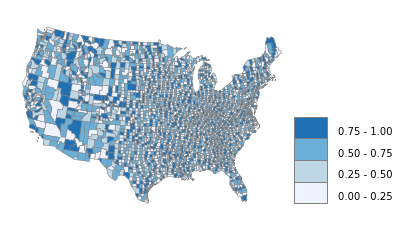

In [18]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_neg]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/8  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()


Calculate gobal Moran's I for the data with the base map

In [19]:
classes = [intervals.get_class(v) for v in all_values_neg]

In [20]:
class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
class_means = [ sum([all_values_neg[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                for j in range(numclass) ]
means = [ class_means[i] for i in classes ]
moransi2(all_values_neg, adjacency_list)

-0.20461722985785957

In [21]:
dataGenerationPath = r'C:\Users\jiali\Desktop\choroplethClassAnalysis\mapGeneration\code'

In [22]:

with open(dataGenerationPath + '\\' + baseMap + '_' + 'all_values_neg.pickle', 'wb') as f:
    pickle.dump(all_values_neg,f)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jiali\\Desktop\\choroplethClassAnalysis\\mapGeneration\\code\\us_all_values_neg.pickle'

#### 2. Generate spatial data (all values) with NO spatial autocorrelation for the enumeration units

In [23]:
# randomly select values for nonpattern maps
all_values_nonAuto = [random.uniform(0, 1) for i in range(len(all_features))] 

In [24]:
unique_values = list(set(all_values_nonAuto))
m = len(all_values_nonAuto)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

3109 3109 0.0008228936285360477 0.9995663707230386


In [25]:
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.25], [0.25 - 0.5], [0.5 - 0.75], [0.75 - 1]

In [26]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

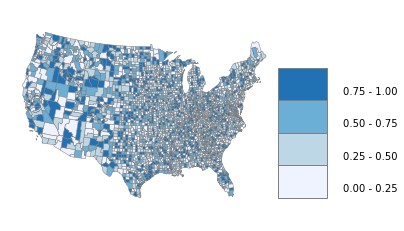

In [27]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_nonAuto]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()

In [28]:
classes = [intervals.get_class(v) for v in all_values_nonAuto]

In [29]:
class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
class_means = [ sum([all_values_nonAuto[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                for j in range(numclass) ]
means = [ class_means[i] for i in classes ]
moransi2(all_values_nonAuto, adjacency_list)

-0.0002735721549165386

In [30]:
with open(dataGenerationPath + '\\'+ baseMap + '_' +'all_values_nonAuto.pickle', 'wb') as f:
    pickle.dump(all_values_nonAuto,f)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jiali\\Desktop\\choroplethClassAnalysis\\mapGeneration\\code\\us_all_values_nonAuto.pickle'

#### 3. Generate spatial data (all values) with POSITIVE spatial autocorrelation for the enumeration units

We use midpoint displacement interpolation to generate a grid with some trend to synthesize data with positive spatial autocorrelation.

The next a couple of cells are the functions needed for this section

In [31]:
def f(delta, x):
    return sum(x)/len(x)+delta*random.gauss(0,1)

def midpoint2d(maxlevel, sigma, H, addition=False):
    N = int(math.pow(2, maxlevel))
    X = [ [0]*(N+1) for x in range(N+1)]
    delta = sigma
    X[0][0] = delta*random.gauss(0,1)
    X[0][N] = delta*random.gauss(0,1)
    X[N][0] = delta*random.gauss(0,1)
    X[N][N] = delta*random.gauss(0,1)
    D = N
    d = int(N/2)
    for stage in range(1, maxlevel+1):
        delta = delta*math.pow(0.5, 0.5*H)
        for x in range(d, N-d+1, D):
            for y in range(d, N-d+1, D):
                X[x][y] = f(delta, [X[x+d][y+d], X[x+d][y-d],
                                    X[x-d][y+d], X[x-d][y-d]])
        if addition is True:
            for x in range(0, N+1, D):
                for y in range(0, N+1, D):
                    X[x][y] += delta*random.gauss(0, 1)
        delta = delta*math.pow(0.5, 0.5*H)
        for x in range(d, N-d+1, D):
            X[x][0] = f(delta,[X[x+d][0],X[x-d][0],X[x][d]])
            X[x][N] = f(delta,[X[x+d][N],X[x-d][N],X[x][N-d]])
            X[0][x] = f(delta,[X[0][x+d],X[0][x-d],X[d][x]])
            X[N][x] = f(delta,[X[N][x+d],X[N][x-d],X[N-d][x]])
        for x in range(d, N-d+1, D):
            for y in range(D, N-d+1, D):
                X[x][y] = f(delta, [X[x][y+d], X[x][y-d],
                                    X[x+d][y], X[x+d][y]])
        for x in range(D, N-d+1, D):
            for y in range(d, N-d+1, D):
                X[x][y] = f(delta, [X[x][y+d], X[x+d][y-d],
                                    X[x+d][y], X[x-d][y]])
        if addition is True:
            for x in range(0, N+1, D):
                for y in range(0, N+1, D):
                    X[x][y] += delta*random.gauss(0, 1)
            for x in range(d, N-d+1, D):
                for y in range(d, N-d+1, D):
                    X[x][y] += delta*random.gauss(0, 1)
        D = int(D/2)
        d = int(d/2)
    return X

In [32]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [33]:
def getValueUnit(envelopes, generatedMatrix, geom_bounds):
    # get generated data for each enumeration unit in the map
    # envelopes are for each unit, generatedMatrix is the generated matrix
    # return a list of value for each unit
    valueListUnit = []
    boundXMin = geom_bounds['xmin']
    boundXMax = geom_bounds['xmax']
    boundXRange = boundXMax - boundXMin
    boundYMin = geom_bounds['ymin']
    boundYMax = geom_bounds['ymax']
    boundYRange = boundYMax - boundYMin
       
    for envelope in envelopes:
        xMid = (envelope[0] + envelope[2])/2
        yMid = (envelope[1] + envelope[3])/2
        
        xIndex = int((xMid - boundXMin) / boundXRange * generatedMatrix.shape[0]) - 1 
        if xIndex < 0:
            xIndex = 0
        yIndex = int((yMid - boundYMin) / boundYRange * generatedMatrix.shape[0]) - 1 
        if yIndex < 0:
            yIndex = 0
        value = generatedMatrix[yIndex][xIndex]
        valueListUnit.append(value)
    return valueListUnit

##### (1) large positive spatial autocorrelation

Conduct midpoint displacement interpolation

In [34]:
maxlevel = 8
sigma = 0.5
H = 0.5
if len(sys.argv) == 4:
    maxlevel = string.atoi(sys.argv[1])
    sigma = string.atof(sys.argv[2])
    H = string.atof(sys.argv[3])
X = midpoint2d(maxlevel, sigma, H)

In [35]:
generatedMatrix = np.array(X)
generatedMatrixNorm = NormalizeData(generatedMatrix)

Visualize generated matrix with some trend

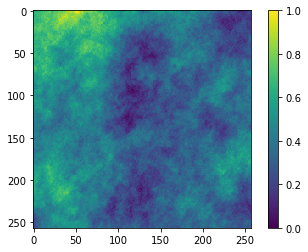

In [36]:
plt.imshow(generatedMatrixNorm, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [37]:
# get value from generated data with MidPoint2.py
all_values_pos_large = getValueUnit(envelopes, generatedMatrixNorm, geom_bounds)
# all_values

In [50]:
all_values_pos_large.sort()

In [53]:
all_values_pos_large.sort(reverse=True)
all_values_pos_large

[0.7047769815673812,
 0.6907775605175291,
 0.6883139193284159,
 0.6862462702862907,
 0.6778216510002049,
 0.6678259326534792,
 0.6663392889620253,
 0.665028554532649,
 0.6535601303574539,
 0.6368291573755088,
 0.6330891825375902,
 0.6281989003969484,
 0.6228946123073792,
 0.621200162774125,
 0.6205782698598757,
 0.6202429271070834,
 0.617897137207407,
 0.6169624275251182,
 0.6168156999685429,
 0.6161867309608426,
 0.614257619913528,
 0.6132142073799084,
 0.6112030733324441,
 0.6108841663695254,
 0.6102168604168088,
 0.6098154205034878,
 0.6076687861186794,
 0.6072891081734519,
 0.6059683876695694,
 0.6049924173824928,
 0.6036517085981695,
 0.6021429832559463,
 0.6001489067246637,
 0.5953601879486441,
 0.594682522992078,
 0.5941618989489973,
 0.5916041256614698,
 0.5905537965052573,
 0.5891423234378035,
 0.5887835704925135,
 0.5874322150566832,
 0.5870651439578033,
 0.5865950343511731,
 0.5865510745124043,
 0.582646013027107,
 0.5787795707682994,
 0.5665157476594719,
 0.5663909863465071

In [56]:
gaps = [ (all_values_pos_large[i] - all_values_pos_large[i+1]) for i in range(len(all_values_pos_large)-1)]
gaps

[0.013999421049852079,
 0.0024636411891132415,
 0.002067649042125197,
 0.008424619286085844,
 0.009995718346725635,
 0.0014866436914539038,
 0.0013107344293763479,
 0.011468424175195113,
 0.016730972981945036,
 0.003739974837918658,
 0.0048902821406417996,
 0.005304288089569176,
 0.0016944495332541498,
 0.0006218929142493002,
 0.0003353427527923447,
 0.002345789899676376,
 0.0009347096822888146,
 0.000146727556575299,
 0.0006289690077002641,
 0.0019291110473146356,
 0.0010434125336196143,
 0.0020111340474643358,
 0.0003189069629186969,
 0.0006673059527165792,
 0.00040143991332097784,
 0.0021466343848084435,
 0.00037967794522741904,
 0.0013207205038825443,
 0.0009759702870766329,
 0.0013407087843232413,
 0.0015087253422232383,
 0.0019940765312825848,
 0.004788718776019607,
 0.0006776649565660708,
 0.0005206240430807307,
 0.0025577732875274872,
 0.0010503291562125039,
 0.0014114730674538167,
 0.00035875294528997514,
 0.0013513554358303148,
 0.00036707109887990086,
 0.00047010960663018686

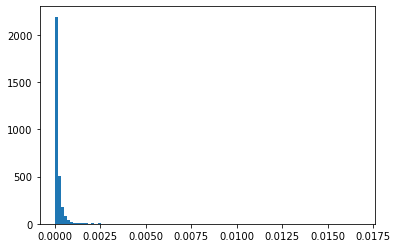

In [57]:
plt.hist(gaps, bins = 100)
plt.show()

In [41]:
unique_values = list(set(all_values_pos_large))
m = len(all_values_pos_large)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

3093 3109 0.04823404204075063 0.7047769815673812


In [39]:
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.25], [0.25 - 0.5], [0.5 - 0.75], [0.75 - 1]

In [42]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

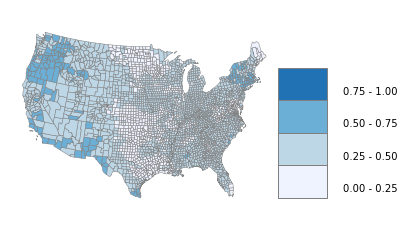

In [43]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_pos_large]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()

In [44]:
classes = [intervals.get_class(v) for v in all_values_pos_large]

In [45]:
# class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
# class_means = [ sum([all_values_pos_large[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
#                 for j in range(numclass) ]
# means = [ class_means[i] for i in classes ]
moransi2(all_values_pos_large, adjacency_list)

0.8499336263035074

In [ ]:
with open(dataGenerationPath + '\\'+ baseMap + '_' +'all_values_pos_large.pickle', 'wb') as f:
    pickle.dump(all_values_pos_large,f)

##### (2) small positive spatial autocorrelation

In [46]:
maxlevel = 12
sigma = 0.1
H = 0.1
if len(sys.argv) == 4:
    maxlevel = string.atoi(sys.argv[1])
    sigma = string.atof(sys.argv[2])
    H = string.atof(sys.argv[3])
X = midpoint2d(maxlevel, sigma, H)

In [47]:
generatedMatrix = np.array(X)
generatedMatrixNorm = NormalizeData(generatedMatrix)

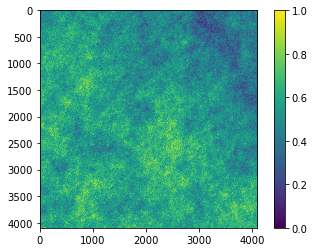

In [48]:
plt.imshow(generatedMatrixNorm, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [49]:
# get value from generated data with MidPoint2.py
all_values_pos_small = getValueUnit(envelopes, generatedMatrixNorm, geom_bounds)
# all_values

In [ ]:
plt.hist(all_values_pos_small)
plt.show()

In [27]:
unique_values = list(set(all_values_pos_small))
m = len(all_values_pos_small)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

3109 3109 0.22672875657271283 0.851694407224588


[0 - 0.25], [0.25 - 0.5], [0.5 - 0.75], [0.75 - 1]

In [28]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

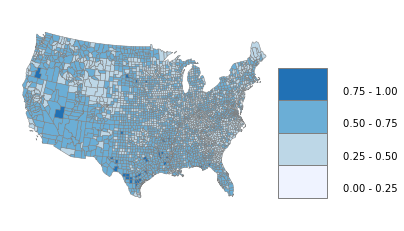

In [29]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_pos_small]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()

In [30]:
classes = [intervals.get_class(v) for v in all_values_pos_small]

In [31]:
# class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
# class_means = [ sum([all_values[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
#                 for j in range(numclass) ]
# means = [ class_means[i] for i in classes ]
moransi2(all_values_pos_small, adjacency_list)

0.45103197520594795

In [32]:
with open(dataGenerationPath + '\\'+ baseMap + '_' +'all_values_pos_small.pickle', 'wb') as f:
    pickle.dump(all_values_pos_small,f)